In [1]:
!python -V

Python 3.9.7


In [2]:
from sklearn.feature_extraction import DictVectorizer
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyctaxi_experiments")


2022/06/28 12:01:25 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2022/06/28 12:01:25 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyctaxi_experiments', tags={}>

In [4]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df


In [5]:
from utils import download_data

download_data(1,4,2021)

-_-_-_-_-_- Fetching Data for 2021/1 


--2022-06-28 12:01:25--  https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2021-01.parquet
Resolving s3.amazonaws.com... 52.217.72.230
Connecting to s3.amazonaws.com|52.217.72.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1333519 (1.3M) [binary/octet-stream]
Saving to: './data/2021/green_tripdata_2021-01.parquet'

     0K .......... .......... .......... .......... ..........  3%  565K 2s
    50K .......... .......... .......... .......... ..........  7%  567K 2s
   100K .......... .......... .......... .......... .......... 11%  575K 2s
   150K .......... .......... .......... .......... .......... 15% 19.1M 1s
   200K .......... .......... .......... .......... .......... 19% 1.31M 1s
   250K .......... .......... .......... .......... .......... 23% 1.01M 1s
   300K .......... .......... .......... .......... .......... 26% 18.2M 1s
   350K .......... .......... .......... .......... .......... 30% 16.2M 1s
   400K .......... .......... ......

-_-_-_-_-_- Fetching Data for 2021/2 


HTTP request sent, awaiting response... 200 OK
Length: 1145679 (1.1M) [binary/octet-stream]
Saving to: './data/2021/green_tripdata_2021-02.parquet'

     0K .......... .......... .......... .......... ..........  4%  276K 4s
    50K .......... .......... .......... .......... ..........  8% 36.5M 2s
   100K .......... .......... .......... .......... .......... 13%  555K 2s
   150K .......... .......... .......... .......... .......... 17% 18.9M 1s
   200K .......... .......... .......... .......... .......... 22% 18.9M 1s
   250K .......... .......... .......... .......... .......... 26%  581K 1s
   300K .......... .......... .......... .......... .......... 31% 18.8M 1s
   350K .......... .......... .......... .......... .......... 35% 18.8M 1s
   400K .......... .......... .......... .......... .......... 40% 19.1M 1s
   450K .......... .......... .......... .......... .......... 44% 18.8M 0s
   500K .......... .......... .......... .......... .......... 49%  631K 0s
   550K .......

-_-_-_-_-_- Fetching Data for 2021/3 


connected.
HTTP request sent, awaiting response... 200 OK
Length: 1474538 (1.4M) [binary/octet-stream]
Saving to: './data/2021/green_tripdata_2021-03.parquet'

     0K .......... .......... .......... .......... ..........  3%  274K 5s
    50K .......... .......... .......... .......... ..........  6% 35.0M 2s
   100K .......... .......... .......... .......... .......... 10%  552K 2s
   150K .......... .......... .......... .......... .......... 13% 18.7M 2s
   200K .......... .......... .......... .......... .......... 17% 1.32M 1s
   250K .......... .......... .......... .......... .......... 20%  961K 1s
   300K .......... .......... .......... .......... .......... 24% 18.9M 1s
   350K .......... .......... .......... .......... .......... 27% 18.1M 1s
   400K .......... .......... .......... .......... .......... 31% 19.1M 1s
   450K .......... .......... .......... .......... .......... 34% 19.1M 1s
   500K .......... .......... .......... .......... .......... 38%  628K 1s
   5

-_-_-_-_-_- Fetching Data for 2021/4 


connected.
HTTP request sent, awaiting response... 200 OK
Length: 1534964 (1.5M) [binary/octet-stream]
Saving to: './data/2021/green_tripdata_2021-04.parquet'

     0K .......... .......... .......... .......... ..........  3%  277K 5s
    50K .......... .......... .......... .......... ..........  6% 32.2M 3s
   100K .......... .......... .......... .......... .......... 10%  558K 2s
   150K .......... .......... .......... .......... .......... 13% 19.1M 2s
   200K .......... .......... .......... .......... .......... 16% 1.28M 2s
   250K .......... .......... .......... .......... .......... 20%  998K 1s
   300K .......... .......... .......... .......... .......... 23% 19.0M 1s
   350K .......... .......... .......... .......... .......... 26% 18.5M 1s
   400K .......... .......... .......... .......... .......... 30% 18.7M 1s
   450K .......... .......... .......... .......... .......... 33% 19.0M 1s
   500K .......... .......... .......... .......... .......... 36%  637K 1s
   5

In [6]:
df_train = read_dataframe('./data/2021/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/2021/green_tripdata_2021-02.parquet')

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [7]:
len(df_train),len(df_val)

(73908, 61921)

In [8]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)


val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

#By using fit_transform, we can create mappings from the beginning,
# but transform ignores the features that not encountered during fit_transform. 
# That's why fit_transform for train data and transform for validation data.


In [9]:
target = "duration"

y_train = df_train[target].values
y_val = df_val[target].values


In [10]:
X_train.shape,y_train.shape

((73908, 13221), (73908,))

In [11]:
X_val.shape,y_val.shape

((61921, 13221), (61921,))

In [12]:
### Train LinearRegression

lr = LinearRegression()

lr.fit(X_train,y_train)

y_pred = lr.predict(X_val)


mean_squared_error(y_val,y_pred, squared=False)

7.75871520559622

In [13]:
plt.style.use("ggplot")

/home/elegant00/miniconda3/envs/Ml_Ops/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/elegant00/miniconda3/envs/Ml_Ops/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


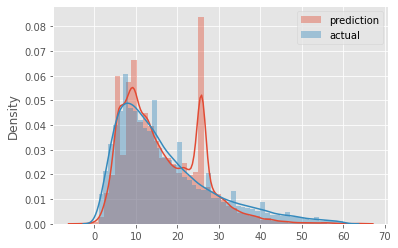

In [14]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend();

In [15]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [16]:
# Save the model as an artifact

with mlflow.start_run():
    mlflow.set_tag("developer","Andrew")
    mlflow.log_param("train-data-path","./data/2021/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/2021/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    lr = Lasso(alpha)

    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric("rmse",rmse )
    mlflow.log_artifact(local_path="models/lin_reg.bin",artifact_path="models_pickle")


### Setting up hyperparameter tunning tracking with MLFlow

In [17]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope 

In [18]:
train = xgb.DMatrix(X_train,label=y_train)
valid = xgb.DMatrix(X_val,label=y_val)

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("Model","xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain =train,
            num_boost_round=1000,
            evals=[(valid,"validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val,y_pred,squared=False)
        mlflow.log_metric("rmse",rmse)
    return{'loss':rmse,'status':STATUS_OK} # SIGNAL FOR SUCCESSFUL OPTIMIZATION

In [20]:
search_space = {
    'max_depth' : scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate' : hp.loguniform('learning_rate',-3,0), # exp(-3) and exp(0)
    'reg_alpha' : hp.loguniform('reg_alpha',-5,-1), 
    'reg_lambda' : hp.loguniform('reg_lambda',-6,-1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective' : 'reg:linear',
    'seed' : 42, # Assign SEED
    #'tree_method' : 'gpu_hist' # Optional : use GPU

}


## Create a best_result variable


#best_result = fmin(
#    fn=objective,
#    space=search_space,
#    algo=tpe.suggest,
#    max_evals=50,
#    trials=Trials()
#)


Where `hp.log_uniform` returns a value according to `exp(uniform(low,high))` So the return is uniformly distributed.

### Training an Xgboost model with the best params obtained by Mlflow

### Setting up hyperparameter tunning tracking with MLFlow

In [21]:

best_params = {
    'learning_rate': 0.09585355369315604,
    'max_depth': 30,
    'min_child_weight': 1.060597050922164,
    'objective': 'reg:linear',
    'reg_alpha': 0.018060244040060163,
    'reg_lambda': 0.011658731377413597,
    'seed': 42
}

mlflow.xgboost.autolog()

#booster = xgb.train(
#    params=best_params,
#    dtrain =train,
#    num_boost_round=1000,
#    evals=[(valid,"validation")],
#    early_stopping_rounds=50
#)

#### 2.4 Model Management 

Experiment tracking is the process of saving all experiment related information that you care about for every experiment you run.   



![alt](https://i0.wp.com/neptune.ai/wp-content/uploads/MLOps_cycle.jpg?resize=1024%2C576&ssl=1)

**Problems** with tradicional approach:
- Error Prone : Files and directories are manually created (For many models it's even more confusing)
- No versioning 
- No model lineage : We don't know what hyper-parameters where used.

In [22]:
mlflow.xgboost.autolog(disable=True)

In [23]:
with mlflow.start_run():
    train = xgb.DMatrix(X_train,label = y_train)
    valid = xgb.DMatrix(X_val,label = y_val)
    

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }
    
    mlflow.log_params(best_params) # Log from current run
    
    booster = xgb.train(
        params=best_params,
        dtrain= train,
        num_boost_round = 1000,
        evals = [(valid,"validation")],
        early_stopping_rounds = 50,
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val,y_pred,squared=False)
    mlflow.log_metric("rmse",rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


    

[12:01:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.48425
[1]	validation-rmse:17.95634
[2]	validation-rmse:16.59114
[3]	validation-rmse:15.37412
[4]	validation-rmse:14.29011
[5]	validation-rmse:13.32800
[6]	validation-rmse:12.47570
[7]	validation-rmse:11.72140
[8]	validation-rmse:11.05888
[9]	validation-rmse:10.47583
[10]	validation-rmse:9.96483
[11]	validation-rmse:9.51784
[12]	validation-rmse:9.12620
[13]	validation-rmse:8.78522
[14]	validation-rmse:8.49037
[15]	validation-rmse:8.23332
[16]	validation-rmse:8.01179
[17]	validation-rmse:7.81822
[18]	validation-rmse:7.65209
[19]	validation-rmse:7.50743
[20]	validation-rmse:7.38235
[21]	validation-rmse:7.27382
[22]	validation-rmse:7.17865
[23]	validation-rmse:7.09606
[24]	validation-rmse:7.02481
[25]	validation-rmse:6.96336
[26]	validation-rmse:6.91001
[27]	validation-rmse:6.86273
[28]	validation-rmse:6.82111
[29]	validation-rmse:6.78450
[30]	valida

/home/elegant00/miniconda3/envs/Ml_Ops/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Where `hp.log_uniform` returns a value according to `exp(uniform(low,high))` So the return is uniformly distributed.


In [26]:
# Training extra models
# Doesn't work 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):
    with mlflow.start_run():
        mlflow.log_param("train-data-path", "./data/2021/green_tripdata_2021-01.parquet")
        mlflow.log_param("valid-data-path", "./data/2021/green_tripdata_2021-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

KeyboardInterrupt: 

#### 2.4 Model Management 

Experiment tracking is the process of saving all experiment related information that you care about for every experiment you run.   



![alt](https://i0.wp.com/neptune.ai/wp-content/uploads/MLOps_cycle.jpg?resize=1024%2C576&ssl=1)

**Problems** with tradicional approach:
- Error Prone : Files and directories are manually created (For many models it's even more confusing)
- No versioning 
- No model lineage : We don't know what hyper-parameters where used.

### 2.5 Model Registry



### Motivation
- Tracking changes , registry models with MLFlow
- Wondering what has changed ?
- Improving communication.
- Only list what models are production Ready
- Add CI/CD Code.




